<a href="https://colab.research.google.com/github/maxbentley/datasciencefund/blob/main/Unit6/Max_BentU6Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 6 Project

I'm doing baseball again. Wow!

This time, I'm trying to model a catcher's caught stealing percentage using other catcher throwing statistics, i.e. arm strength, pop time, etc.

## Setup

Let's import some libraries and the data:

In [1]:
import pandas as pd
!pip install bambi
import bambi as bmb
import arviz as az

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.2/109.2 kB 771.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.1 MB/s eta 0:00:00


In [2]:
catcher_data = pd.read_csv("https://raw.githubusercontent.com/maxbentley/datasciencefund/refs/heads/main/Data/catcher_throwing.csv")

catcher_data

,player_id,player_name,team_name,start_year,end_year,sb_attempts,catcher_stealing_runs,caught_stealing_above_average,n_cs,rate_cs,...,runner_distance_from_second,pop_time,exchange_time,arm_strength,n_xcs_with_flight_over_xcs,n_xcs_with_exchange_over_xcs,n_xcs_with_accuracy_over_xcs,n_xcs_with_ground_other_over_xcs,n_xcs_with_onfly_other_over_xcs,n_xcs_with_untracked_other_over_xcs
0,663698,"Bart, Joey",PIT,2024,2024,60,-0.097009,-0.149244,13,0.216667,...,53.545147,1.917474,0.691053,78.900233,0.191147,-3.129056,0.566264,0.875636,0.154765,1.192000
1,686676,"Lee, Korey",CWS,2024,2024,67,2.172157,3.341779,18,0.268657,...,55.284056,1.828783,0.633478,84.687734,6.125440,0.315639,0.540390,0.284665,-3.924354,0.000000
2,666310,"Naylor, Bo",CLE,2024,2024,59,-0.991714,-1.525714,9,0.152542,...,54.737418,1.924875,0.641075,78.082162,-1.317310,0.888435,-0.284148,1.129578,-1.797115,-0.145153
3,641680,"Heim, Jonah",TEX,2024,2024,83,-4.273332,-6.574357,10,0.120482,...,55.264855,1.926338,0.690141,80.999756,2.293291,-4.327161,2.740336,1.070167,-8.274813,-0.076176
4,571912,"Maile, Luke",CIN,2024,2024,34,-0.782793,-1.204297,7,0.205882,...,57.174991,1.955393,0.641214,78.764144,-0.525259,1.159366,-1.568776,-0.486196,0.216568,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,575929,"Contreras, Willson",STL,2024,2024,36,0.794213,1.221865,7,0.194444,...,55.368373,1.966111,0.707111,81.138686,1.282196,-1.449839,0.678358,-0.525773,0.324923,0.912001
62,455117,"Maldonado, Martín",CWS,2024,2024,30,-1.854798,-2.853536,2,0.066667,...,54.723562,1.898105,0.680263,82.061224,0.963099,-1.595001,-0.424762,-0.146614,-1.183447,-0.466811
63,543877,"Vázquez, Christian",MIN,2024,2024,43,-1.922646,-2.957917,6,0.139535,...,56.382624,1.918926,0.595667,76.536740,-2.093576,0.124924,0.141733,-0.290136,-0.652925,-0.187937
64,680728,"Del Castillo, Adrian",AZ,2024,2024,22,-1.127932,-1.735280,1,0.045455,...,53.780076,2.005000,0.685143,75.399246,-1.253330,-0.419591,-0.127081,0.034165,0.030557,0.000000


There are a *lot* of columns in this dataset, and I will not be using most of them. I'll delete some of these now.

In [3]:
# Deleting columns that are already models in of themselves (statcast's "expected" stolen base metrics)
catcher_data = catcher_data.drop(['catcher_stealing_runs', 'cs_aa_per_throw', 'est_cs_pct', 'caught_stealing_above_average', 'n_xcs_with_flight_over_xcs', 'n_xcs_with_exchange_over_xcs', 'n_xcs_with_accuracy_over_xcs', 'n_xcs_with_ground_other_over_xcs', 'n_xcs_with_onfly_other_over_xcs', 'n_xcs_with_untracked_other_over_xcs'], axis=1)

# Deleting columns that have nothing to do with the stolen bases themselves (year, team name and player ID)
catcher_data = catcher_data.drop(['player_id', 'team_name', 'start_year', 'end_year'], axis=1)

catcher_data

,player_name,sb_attempts,n_cs,rate_cs,seasonal_runner_speed,runner_distance_from_second,pop_time,exchange_time,arm_strength
0,"Bart, Joey",60,13,0.216667,28.210000,53.545147,1.917474,0.691053,78.900233
1,"Lee, Korey",67,18,0.268657,28.300000,55.284056,1.828783,0.633478,84.687734
2,"Naylor, Bo",59,9,0.152542,28.455932,54.737418,1.924875,0.641075,78.082162
3,"Heim, Jonah",83,10,0.120482,28.632530,55.264855,1.926338,0.690141,80.999756
4,"Maile, Luke",34,7,0.205882,28.700000,57.174991,1.955393,0.641214,78.764144
...,...,...,...,...,...,...,...,...,...
61,"Contreras, Willson",36,7,0.194444,28.744444,55.368373,1.966111,0.707111,81.138686
62,"Maldonado, Martín",30,2,0.066667,28.696667,54.723562,1.898105,0.680263,82.061224
63,"Vázquez, Christian",43,6,0.139535,28.551163,56.382624,1.918926,0.595667,76.536740
64,"Del Castillo, Adrian",22,1,0.045455,28.881818,53.780076,2.005000,0.685143,75.399246


The remaining columns are much more suited to our task than the others, as we want to try and predict stolen base percentage (rate_cs) based on more fundamental metrics that the catcher has control over, such as the strength of the catcher's arm (arm_strength) or the time it takes for the catcher to get rid of the ball (pop_time).

## Modelling time!

First off, I'm going to hypothesize how all of these variables connect with one another. Here's a causal DAG of how I think these are related:

Thick lines represent connections, while dotted lines represent weak connections.

![](https://drive.google.com/uc?export=view&id=1KPK6irLRTN9XK2nTPvhnPHyjw1wrlOPZ)


There's a lot to unpack here, so let me explain what I think is going on:

- I think the strength of a catcher's arm (meaning how fast they throw the bsaeball to second base) is a factor in a catcher's pop time (how long it takes from the catcher receiving the baseball to the fielder at second base receiving it), as well as being weakly related to the number of stolen base attempts for a particular catcher and that catcher's stolen base rate (which is ultimately what I am trying to predict). For the direct relationship, how strong a catcher's throws are will directly impact how long it takes for the fielder to receive the ball, as stronger throws will shorten the time the ball spends in the air. For the indirect relationships, a catcher with a strong arm might see less stolen base attempts, as potential runners may stray away from attempting steals for fear of being tagged out; the same logic goes for the caught-stealing rate, as strong-armed catchers might cause unsuspecting baserunners off-guard, increasing their stolen base rate.
- I think a catcher's exchange time (how fast the catcher gets rid of the ball) is directly related to a catcher's pop time, as the faster the catcher gets rid of the ball, the faster the fielder receives it. I do worry that this specific statistic might contribute to overfitting in the model, as its impact on every other metric is (I predict) negligible and it's a relatively small part anyways.
- I think a catcher's pop time is directly related to their caught stealing rate, as a slower pop time would likely increase the amount of bases stolen, lowering a catcher's caught stealing rate. I also think it's weakly related to the amount of stolen base attempts a catcher sees, as a slower pop time could mean more stolen base attempts and vice versa.
- I think a catcher's stolen base attempts against are largely downstream of other factors, as they are a reaction to many other metrics both present and not in this project. What I do think is true, though, is that they will be a predictor of a catcher's caught stealing rate, as a high amount of attempts indicates that runners believe it would be easier to steal bases on that specific catcher.

## Let's build!

I'm essentially just going to create a bunch of models that I think could work using Bambi and see what works best.

In [4]:
# Model that assumes everything that I said in my DAG was true, including weak relationships
model_all = bmb.Model("rate_cs ~ pop_time + sb_attempts + arm_strength + (pop_time|arm_strength) + "
                      "(pop_time|exchange_time) + (sb_attempts|arm_strength) + (sb_attempts|pop_time)", data=catcher_data)
idata_all = model_all.fit(idata_kwargs={'log_likelihood': True})

# Model that assumes everything I said in my DAG was true, EXCLUDING weak relationships
model_nonweak = bmb.Model("rate_cs ~ pop_time + sb_attempts + (pop_time|arm_strength) + (pop_time|exchange_time)", data=catcher_data)
idata_nonweak = model_nonweak.fit(idata_kwargs={'log_likelihood': True})

# Model that excludes both non-weak relationships and exchange_time (possible overfitting)
model_nonexchange = bmb.Model("rate_cs ~ pop_time + sb_attempts + (pop_time|arm_strength)", data=catcher_data)
idata_nonexchange = model_nonexchange.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

ERROR:pymc.stats.convergence:There were 338 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

ERROR:pymc.stats.convergence:There were 76 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

Output()

ERROR:pymc.stats.convergence:There were 100 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Note: if you're seeing four more chains in my jupyter notebook than there should be, it's because the code block below was originally merged with the code block above.

In [5]:
# Separated these two code blocks because the first code block takes WAY longer to run than the second

# Model that only includes variables that directly impact rate_cs per my DAG (incl. weak relationships)
model_direct = bmb.Model("rate_cs ~ pop_time + sb_attempts + arm_strength", data=catcher_data)
idata_direct = model_direct.fit(idata_kwargs={'log_likelihood': True})

# Model that only includes variables that directly impact rate_cs per my DAG (excl. weak relationships)
model_direct_nonweak = bmb.Model("rate_cs ~ pop_time + sb_attempts", data=catcher_data)
idata_direct_nonweak = model_direct_nonweak.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Output()

Output()

Lots of divergences, whoa! I think this is mainly due to the large amounts of hierarchies that I chose - lots of connections means that pymc might not run as well as if there were less.

For all of my models, I'm going to just let Bambi choose the priors based on the data. I'm doing this for two reasons: first, because Bambi's priors are intentionally pretty weak, meaning that the model should reason out the "true" distribution quickly. Even though some of my data points are times, which are all positive, the model should be adjusting to use positive values for those. The second reason is because I'm lazy, and manually setting my priors will probably take much longer for me to make and debug while still (probably) getting the same results.

Let's see what priors Bambi chose for us:

In [ ]:
model_all

       Formula: rate_cs ~ pop_time + sb_attempts + arm_strength + (pop_time|arm_strength) + (pop_time|exchange_time) + (sb_attempts|arm_strength) + (sb_attempts|pop_time)
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 9.5687)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
        
        Group-level effects
            1|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 9.5687))
            pop_time|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6258))
            1|exchange_time ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 9.5687))
            pop_time|exchange_time ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6258))
            sb_attempts|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 0.0113))
        

In [ ]:
model_nonweak

       Formula: rate_cs ~ pop_time + sb_attempts + (pop_time|arm_strength) + (pop_time|exchange_time)
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 7.0139)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
        
        Group-level effects
            1|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 7.0139))
            pop_time|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6258))
            1|exchange_time ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 7.0139))
            pop_time|exchange_time ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6258))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object 

In [ ]:
model_nonexchange

       Formula: rate_cs ~ pop_time + sb_attempts + (pop_time|arm_strength)
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 7.0139)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
        
        Group-level effects
            1|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 7.0139))
            pop_time|arm_strength ~ Normal(mu: 0.0, sigma: HalfNormal(sigma: 3.6258))
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_direct

       Formula: rate_cs ~ pop_time + sb_attempts + arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 9.5687)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_direct_nonweak

       Formula: rate_cs ~ pop_time + sb_attempts
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 7.0139)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

The skeleton of each model looks pretty similar - Normals for the predictor variables, a Half Student-T for the standard deviation, and Normals/Half-Normals for the hyperpriors. Let's see first how they compare:

In [6]:
catch_comp = az.compare( {"all":idata_all, "all_nonweak":idata_nonweak, "nonweak_exchange":idata_nonexchange, "direct":idata_direct, "direct_nonweak":idata_direct_nonweak} )
catch_comp

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimat

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
all,0,99.844741,73.356872,0.000000,1.000000e+00,5.062615,0.000000,True,log
all_nonweak,1,79.151814,46.325955,20.692928,2.209899e-13,5.860983,2.180074,True,log
nonweak_exchange,2,69.786630,34.541414,30.058112,0.000000e+00,7.854764,3.582483,True,log
direct_nonweak,3,65.503586,5.014289,34.341155,0.000000e+00,8.695705,4.310937,False,log
direct,4,65.049199,5.709137,34.795542,0.000000e+00,8.457573,4.113310,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

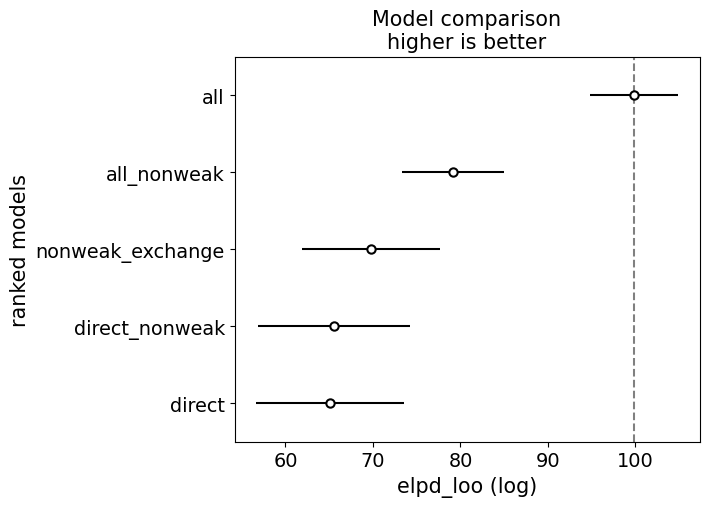

In [7]:
az.plot_compare(catch_comp)

According to the elpd_loo calculations, right now, the full non-weak model, followed by the full model, followed by the non-exchange non-weak model, followed by the direct-only models (which were extremely similar). The problem? Every single model that contains a hierarchy has a "warning" flag attached to it, meaning that the outputs that the model gives are very unreliable. If you run the models yourself a different time, you'll receive wildly different elpd_loo values, especially the two "leading" models. Let's try again!

## Model-building 2

I'm going to try and see what happens when I replace all of the hierarchies with interactions. They should roughly have the same result, as the direction of the interaction should be similar, but we'll see either way.

In [ ]:
# Model that assumes everything that I said in my DAG was true, including weak relationships
model_allInt = bmb.Model("rate_cs ~ pop_time + sb_attempts + arm_strength + pop_time:arm_strength + "
                      "pop_time:exchange_time + sb_attempts:arm_strength + sb_attempts:pop_time", data=catcher_data)
idata_allInt = model_allInt.fit(idata_kwargs={'log_likelihood': True})

# Model that assumes everything I said in my DAG was true, EXCLUDING weak relationships
model_nonweakInt = bmb.Model("rate_cs ~ pop_time + sb_attempts + pop_time:arm_strength + pop_time:exchange_time", data=catcher_data)
idata_nonweakInt = model_nonweakInt.fit(idata_kwargs={'log_likelihood': True})

# Model that excludes both non-weak relationships and exchange_time (possible overfitting)
model_nonexchangeInt = bmb.Model("rate_cs ~ pop_time + sb_attempts + pop_time:arm_strength", data=catcher_data)
idata_nonexchangeInt = model_nonexchangeInt.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Output()

Output()

Output()

Output()

Less divergences! Yay! Let's look at our priors:

In [ ]:
model_allInt

       Formula: rate_cs ~ pop_time + sb_attempts + arm_strength + pop_time:arm_strength + pop_time:exchange_time + sb_attempts:arm_strength + sb_attempts:pop_time
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 12.5256)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
            pop_time:arm_strength ~ Normal(mu: 0.0, sigma: 0.0499)
            pop_time:exchange_time ~ Normal(mu: 0.0, sigma: 2.104)
            sb_attempts:arm_strength ~ Normal(mu: 0.0, sigma: 0.0001)
            sb_attempts:pop_time ~ Normal(mu: 0.0, sigma: 0.0058)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the poste

In [ ]:
model_nonweakInt

       Formula: rate_cs ~ pop_time + sb_attempts + pop_time:arm_strength + pop_time:exchange_time
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 10.6746)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            pop_time:arm_strength ~ Normal(mu: 0.0, sigma: 0.0499)
            pop_time:exchange_time ~ Normal(mu: 0.0, sigma: 2.104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_nonexchangeInt

       Formula: rate_cs ~ pop_time + sb_attempts + pop_time:arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 10.3361)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            pop_time:arm_strength ~ Normal(mu: 0.0, sigma: 0.0499)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Pretty normal. Let's take a look at the elpd_loo's:

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
all,0,68.221236,7.655372,0.000000,9.851826e-01,8.365684,0.000000,True,log
all_nonweak,1,67.206768,6.541469,1.014467,6.458163e-16,8.356944,0.964957,False,log
direct_nonweak,2,65.396103,5.150806,2.825132,1.481740e-02,8.779836,2.454914,False,log
direct,3,65.036696,5.708579,3.184540,1.215645e-17,8.455665,2.211918,False,log
nonweak_exchange,4,64.729058,5.940163,3.492177,0.000000e+00,8.464510,2.212388,False,log


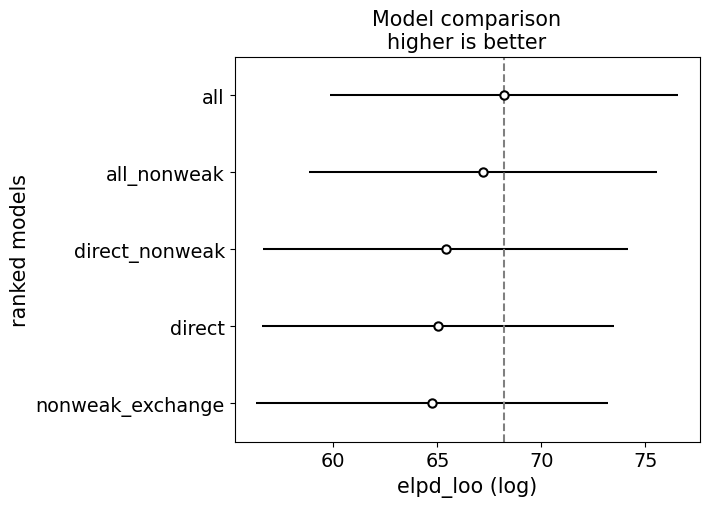

In [ ]:
catch_compInt = az.compare( {"all":idata_allInt, "all_nonweak":idata_nonweakInt, "nonweak_exchange":idata_nonexchangeInt, "direct":idata_direct, "direct_nonweak":idata_direct_nonweak} )
az.plot_compare(catch_compInt)
catch_compInt

None of these models are very different from one another at all, ugh! The "all" models (both including weak and non-weak models) are technically better than the non-weak (and non-exchange) models based on this sampling, but it's probably just noise.

## Look under the hood

Let's try to find out why none of these elpd_loos are any better than the others by examining the fit of the posterior predictive checks of the most variable-heavy and variable-light models:

In [ ]:
import pymc as pm

In [ ]:
# "all" Bambi model converted to pymc
with pm.Model() as pymc_all:
    # priors
    intercept = pm.Normal("α", mu=0.1878, sigma=12.5256)
    b1_pop_time = pm.Normal("β1", mu=0, sigma=3.6258)
    b2_sb_attempts = pm.Normal("β2", mu=0, sigma=0.113)
    b3_arm_strength = pm.Normal("β3", mu=0, sigma=0.0823)
    b4_interaction = pm.Normal("β4", mu=0, sigma=2.104)
    σ = pm.HalfStudentT("σ", nu = 4, sigma = 0.0931)

    #likelihood
    #the linear part of the model is put directly into mu
    # i probably should've made this into a "Deterministic" for readability reasons but who cares
    # also note: i'm not recreating the same distributions for the interactions that bambi made,
    # as mr. arredondo explained to me that interactions are just the product of the interactants
    y = pm.Normal("y_pred",
                  mu=intercept + b1_pop_time * catcher_data['pop_time'] + b2_sb_attempts * catcher_data['sb_attempts'] +
                  b3_arm_strength * catcher_data['arm_strength'] + b4_interaction * catcher_data['pop_time'] * catcher_data['exchange_time'] +
                  b1_pop_time * b3_arm_strength * catcher_data['arm_strength'] * catcher_data['pop_time'] +
                  b2_sb_attempts * b3_arm_strength * catcher_data['arm_strength'] * catcher_data['sb_attempts'] +
                  b2_sb_attempts * b1_pop_time * catcher_data['pop_time'] * catcher_data['sb_attempts'],
                  sigma=σ,
                  observed=catcher_data['rate_cs'])
    idata_pymc_all = pm.sample()

Output()

Output()

ERROR:pymc.stats.convergence:There were 291 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Divergences are back, weird.

Output()

<Axes: xlabel='y_pred'>

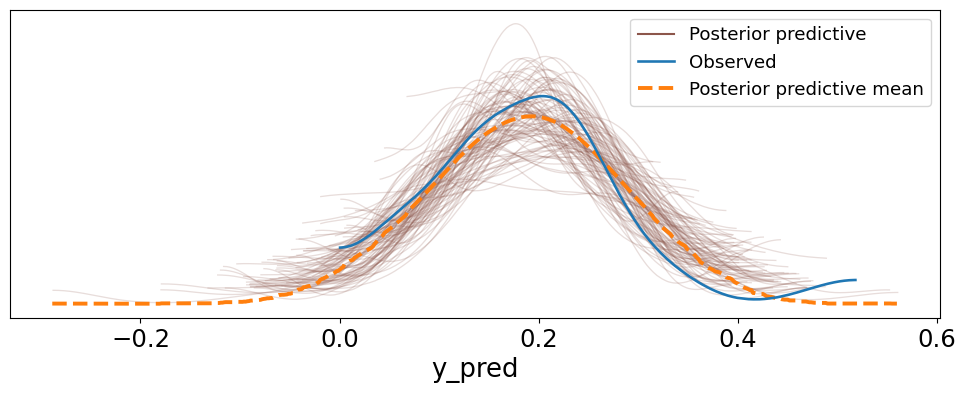

In [ ]:
pm.sample_posterior_predictive(idata_pymc_all, model=pymc_all, extend_inferencedata=True)
az.plot_ppc(idata_pymc_all, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C0", "C1"])

That fits... okay. The individual estimation distributions seem to vary a lot, but it's not *horrible* overall--the mode is undershot and the right side is overestimated, but the left side is near perfect. I think the fact that the fit is merely passable is bad though, since we're incorporating so many variables into the model.

In [ ]:
# "direct, nonweak" Bambi model converted to pymc
with pm.Model() as pymc_d_nonweak:
    # priors
    intercept = pm.Normal("α", mu=0.1878, sigma=7.0139)
    b1_pop_time = pm.Normal("β1", mu=0, sigma=3.6258)
    b2_sb_attempts = pm.Normal("β2", mu=0, sigma=0.113)
    σ = pm.HalfStudentT("σ", nu = 4, sigma = 0.0931)

    # likelihood
    # the linear part of the model is put directly into mu
    # look at how much shorter this is!
    y = pm.Normal("y_pred",
                  mu=intercept + b1_pop_time * catcher_data['pop_time'] + b2_sb_attempts * catcher_data['sb_attempts'],
                  sigma=σ,
                  observed=catcher_data['rate_cs'])
    idata_pymc_d_nonweak = pm.sample()

Output()

Output()

Divergences are gone again, probably due to the lower amount of variables.

Output()

<Axes: xlabel='y_pred'>

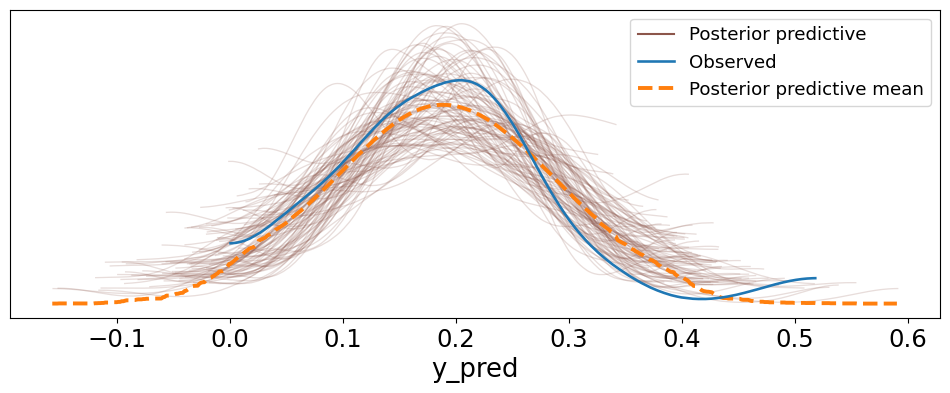

In [ ]:
pm.sample_posterior_predictive(idata_pymc_d_nonweak, model=pymc_d_nonweak, extend_inferencedata=True)
az.plot_ppc(idata_pymc_d_nonweak, num_pp_samples=100, figsize=(12, 4), colors=["C5", "C0", "C1"])

Okay. That's the exact same graph. I mean, not really, but the difference is probably just noise anyways. It seems that nothing changed *at all* here when adding different connections and variables to the model.

## How low can we go?

What I mean by that is: how many variables do we need to get a reasonably good elpd_loo in the first place? Is there a combination of two variables that can get us a better elpd_loo than this one? Can we get any better with just one? Let's see!

In [ ]:
# model time: two-predictor edition!

# Incorporates pop time, interaction with exchange time
model_pop_exch = bmb.Model("rate_cs ~ pop_time + pop_time:exchange_time", data=catcher_data)
idata_pop_exch = model_pop_exch.fit(idata_kwargs={'log_likelihood': True})

# Incorporates pop time, interaction with arm strength
model_pop_armInt = bmb.Model("rate_cs ~ pop_time + pop_time:arm_strength", data=catcher_data)
idata_pop_armInt = model_pop_armInt.fit(idata_kwargs={'log_likelihood': True})

# Incorporates pop time, arm strength
model_pop_arm = bmb.Model("rate_cs ~ pop_time + arm_strength", data=catcher_data)
idata_pop_arm = model_pop_arm.fit(idata_kwargs={'log_likelihood': True})

# Incorporates stolen base attempts, interaction with arm strength
model_sb_armInt = bmb.Model("rate_cs ~ sb_attempts + sb_attempts:arm_strength", data=catcher_data)
idata_sb_armInt = model_sb_armInt.fit(idata_kwargs={'log_likelihood': True})

# Incorporates stolen base attempts, interaction with pop time
model_sb_pop = bmb.Model("rate_cs ~ sb_attempts + sb_attempts:pop_time", data=catcher_data)
idata_sb_pop = model_sb_pop.fit(idata_kwargs={'log_likelihood': True})

# Incorporates stolen base attempts, arm strength
model_sb_arm = bmb.Model("rate_cs ~ sb_attempts + arm_strength", data=catcher_data)
idata_sb_arm = model_sb_arm.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [ ]:
# model time: single predictor edition!

# Incorporates pop time
model_pop = bmb.Model("rate_cs ~ pop_time", data=catcher_data)
idata_pop = model_pop.fit(idata_kwargs={'log_likelihood': True})

# Incorporates stolen base attempts
model_sb = bmb.Model("rate_cs ~ sb_attempts", data=catcher_data)
idata_sb = model_sb.fit(idata_kwargs={'log_likelihood': True})

# Incorporates arm strength
model_arm = bmb.Model("rate_cs ~ arm_strength", data=catcher_data)
idata_arm = model_arm.fit(idata_kwargs={'log_likelihood': True})

Output()

Output()

Output()

Output()

Output()

Output()

Look at how smoothly those chains are running! I'm so happy!

Let's see the priors and elpd_loo's:

### Model priors (warning: long)

In [ ]:
model_pop_exch

       Formula: rate_cs ~ pop_time + pop_time:exchange_time
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 7.484)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            pop_time:exchange_time ~ Normal(mu: 0.0, sigma: 2.104)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_pop_armInt

       Formula: rate_cs ~ pop_time + pop_time:arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 10.3218)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            pop_time:arm_strength ~ Normal(mu: 0.0, sigma: 0.0499)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_pop_arm

       Formula: rate_cs ~ pop_time + arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 9.5532)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_sb_armInt

       Formula: rate_cs ~ sb_attempts + sb_attempts:arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 0.7964)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            sb_attempts:arm_strength ~ Normal(mu: 0.0, sigma: 0.0001)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_sb_arm

       Formula: rate_cs ~ sb_attempts + arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 6.5358)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_sb_pop

       Formula: rate_cs ~ sb_attempts + sb_attempts:pop_time
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 0.8027)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
            sb_attempts:pop_time ~ Normal(mu: 0.0, sigma: 0.0058)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_pop

       Formula: rate_cs ~ pop_time
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 6.9927)
            pop_time ~ Normal(mu: 0.0, sigma: 3.6258)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_arm

       Formula: rate_cs ~ arm_strength
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 6.5131)
            arm_strength ~ Normal(mu: 0.0, sigma: 0.0823)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

In [ ]:
model_sb

       Formula: rate_cs ~ sb_attempts
        Family: gaussian
          Link: mu = identity
  Observations: 66
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.1878, sigma: 0.5923)
            sb_attempts ~ Normal(mu: 0.0, sigma: 0.0113)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 0.0931)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

### Results

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:795: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
all,0,68.221236,7.655372,0.000000,7.674268e-01,8.365684,0.000000,True,log
all_nonweak,1,67.206768,6.541469,1.014467,1.984678e-14,8.356944,0.964957,False,log
pop,2,66.177401,3.944435,2.043835,1.226034e-01,8.342393,2.506322,False,log
pop_armInt,3,65.768430,4.727028,2.452806,1.643423e-14,8.170867,2.218313,False,log
pop_arm,4,65.577782,4.941510,2.643454,1.686494e-14,8.218691,2.209674,False,log
pop_exch,5,65.553638,4.691104,2.667598,1.469108e-14,8.383409,2.511090,False,log
direct_nonweak,6,65.396103,5.150806,2.825132,1.747237e-14,8.779836,2.454914,False,log
direct,7,65.036696,5.708579,3.184540,2.268952e-14,8.455665,2.211918,False,log
nonweak_exchange,8,64.729058,5.940163,3.492177,2.653521e-14,8.464510,2.212388,False,log
arm,9,64.254049,3.549670,3.967187,1.183718e-14,8.134992,3.008122,False,log


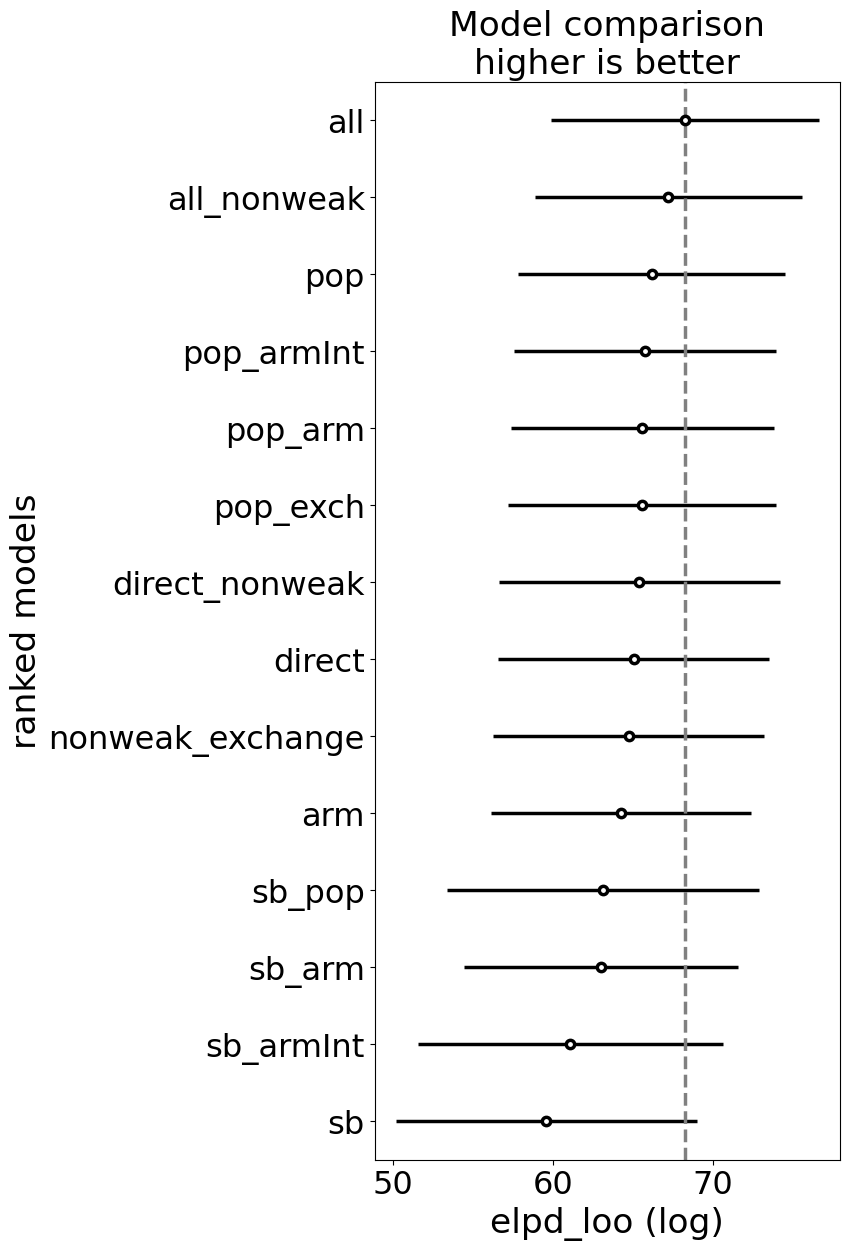

In [ ]:
catch_compInt = az.compare( {"all":idata_allInt, "all_nonweak":idata_nonweakInt, "nonweak_exchange":idata_nonexchangeInt,
                             "direct":idata_direct, "direct_nonweak":idata_direct_nonweak, "pop_exch":idata_pop_exch,
                             "pop_armInt":idata_pop_armInt, "pop_arm":idata_pop_arm, "sb_armInt":idata_sb_armInt, "sb_pop":idata_sb_pop,
                             "sb_arm":idata_sb_arm, "pop":idata_pop, "sb":idata_sb, "arm":idata_arm} )
az.plot_compare(catch_compInt)
catch_compInt

The wide-ranging model still comes out on top ever so slightly, with the non-weak wide-ranging model following close behind, but we've already ruled them both out, since the model has so many variables without a significant improvement in predictive power. The clear winner here, as it seems, is the predictive power of a catcher's pop time. Pop time-derived models perform just a bit better than their non-pop time counterparts, albeit with the caveat that there is very little difference in the performance of any pop time-derived model. Arm strength additionally seems to be a good predictor, as models incorporating arm strength are roughly on-par with pop time-derived models, with the difference in performance possibly being due to just noise. The biggest loser is clearly the predictive power of stolen base attempts--models derived from the metric generally performed poorly, with the stolen base-only model performing the least well. This makes some sense: I thought that the number of stolen base attempts would be downstream from the other statistics like pop time or arm strength; it makes sense for caught stealing rate to be more directly related to pop time or arm strength than just the number of stolen base attempts in general.

One small caveat: all of the models from "pop" down to "arm" probably perform about the same, as the standard error on each model is high enough that the difference in performance is probably just noise.